Yelnur Shauketbek: Convolutional Neural Network for image classification

In [1]:
import torch
from torch import nn
from torch.nn import Conv2d, MaxPool2d, Linear
from torchinfo import summary
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import Lambda
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from timeit import default_timer as timer
import warnings
warnings.filterwarnings("ignore") #Conflict of nn.functional.act_f and torch.act_f

print(f"{torch.__version__=}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device=}")
!nvidia-smi --format=csv --query-gpu=index,name,driver_version,memory.total,memory.used,memory.free

# Set seed for reproducibility
torch.manual_seed(43)
rng = np.random.default_rng(seed=4242)

torch.__version__='1.13.1+cu117'
device=device(type='cuda')
index, name, driver_version, memory.total [MiB], memory.used [MiB], memory.free [MiB]
0, NVIDIA GeForce RTX 3060, 531.61, 12288 MiB, 1016 MiB, 11112 MiB


In [21]:
def MinMaxScaler(img):#[TO COMPLETE]
  # First, we load the data as numpy array
  img_as_array = np.asarray(img)
  tensor = torch.from_numpy(img_as_array) # TO COMPLETE: Transform the array to Tensor for PyTorch
  tensor = tensor.permute(2,0,1) # TO COMPLETE: image is of size (Height, Width, Channels). But torch excepts (C, H, W). Hence, the second thing is to permute.
# TO COMPLETE: Rescale image pixels form [0,255] to [0,1]
  normalized_img = (tensor - torch.min(tensor)) / (torch.max(tensor) - torch.min(tensor))
  
  return normalized_img


'''
NEW DATA LOADING
Note that the previous function must be passed to transforms.Lambda().
'''
dataset = CIFAR10(root='data/', download=True, train=True, transform=transforms.Lambda(MinMaxScaler)) # 50000 samples
test_data = CIFAR10(root='data/', download=True, train=False, transform=transforms.Lambda(MinMaxScaler)) # 10000 samples

Files already downloaded and verified
Files already downloaded and verified


In [22]:
# Let's check the classes and dataset shapes:
classes = dataset.classes
print(f"{classes=}")
print(f"Dataset shape: {dataset.data.shape}")
print(f"Test set shape: {test_data.data.shape}")

classes=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Dataset shape: (50000, 32, 32, 3)
Test set shape: (10000, 32, 32, 3)


In [23]:
dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data/
    Split: Train
    StandardTransform
Transform: Lambda()

In [5]:
# Let's also check whether the dataset is balanced, i.e. there are the same amount of samples for each class
label_count = {}
for _, idx in dataset:
    label = classes[idx]
    if label not in label_count:
        label_count[label] = 0
    label_count[label] += 1
label_count

{'frog': 5000,
 'truck': 5000,
 'deer': 5000,
 'automobile': 5000,
 'bird': 5000,
 'horse': 5000,
 'ship': 5000,
 'cat': 5000,
 'dog': 5000,
 'airplane': 5000}

In [24]:
val_size = 5000
train_size = len(dataset) - val_size

train_data, val_data = random_split(dataset, [train_size, val_size])
print(f"Training samples = {len(train_data)} \nValidation samples = {len(val_data)} \nTest samples = {len(test_data)}")

Training samples = 45000 
Validation samples = 5000 
Test samples = 10000


In [25]:
idx = 50 # 51st data sample
print(train_data[idx]) # (image, label) tensors
print(train_data[idx][0])
assert train_data[idx][0].max().item() <= 1., "Check your MinMaxScaler!"

(tensor([[[0.2627, 0.2581, 0.2581,  ..., 0.4931, 0.5207, 0.4516],
         [0.2258, 0.2258, 0.2350,  ..., 0.5392, 0.5115, 0.4516],
         [0.2442, 0.2535, 0.2673,  ..., 0.5438, 0.4931, 0.4470],
         ...,
         [0.4977, 0.5253, 0.5346,  ..., 0.6544, 0.5161, 0.4055],
         [0.6083, 0.6359, 0.6774,  ..., 0.7604, 0.5806, 0.4700],
         [0.7051, 0.6728, 0.7281,  ..., 0.7696, 0.5760, 0.5115]],

        [[0.3088, 0.3041, 0.2995,  ..., 0.5714, 0.6037, 0.5253],
         [0.2719, 0.2673, 0.2719,  ..., 0.6221, 0.5945, 0.5300],
         [0.2857, 0.2949, 0.3041,  ..., 0.6313, 0.5760, 0.5253],
         ...,
         [0.5530, 0.5806, 0.5899,  ..., 0.7235, 0.6406, 0.5392],
         [0.6820, 0.7051, 0.7465,  ..., 0.7742, 0.6959, 0.5853],
         [0.7742, 0.7327, 0.7972,  ..., 0.8295, 0.7558, 0.6498]],

        [[0.3456, 0.3410, 0.3410,  ..., 0.6359, 0.6728, 0.5899],
         [0.3041, 0.2995, 0.3088,  ..., 0.6912, 0.6636, 0.5945],
         [0.3226, 0.3364, 0.3502,  ..., 0.7005, 0.6406, 0

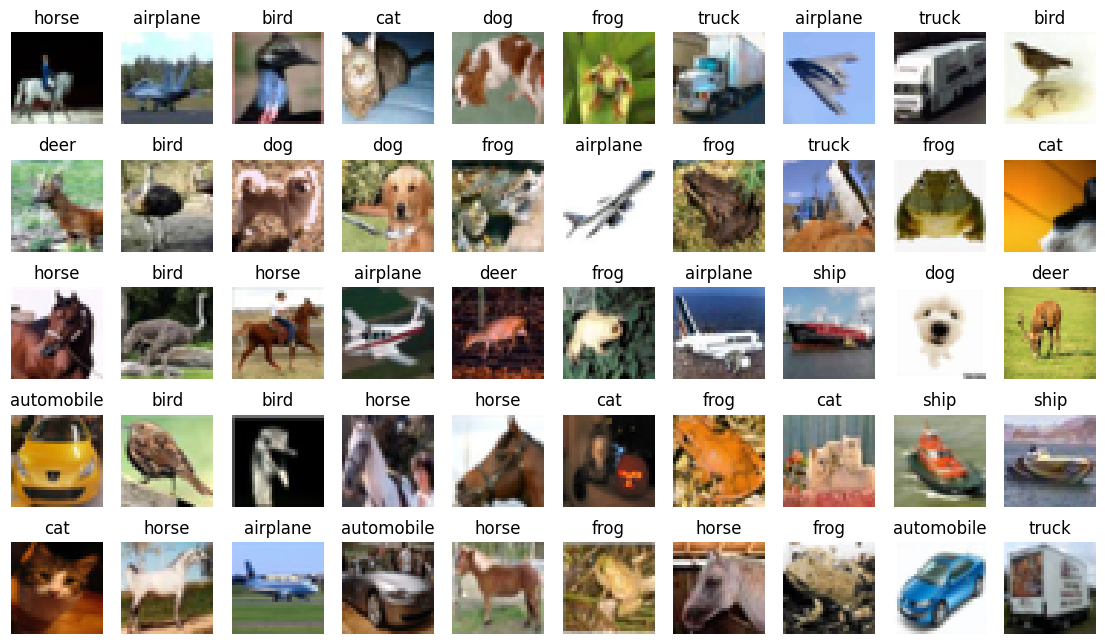

In [26]:
img_chan, img_height, img_width = train_data[idx][0].shape #Channel, Height, Width

# Plots
n_rows = 5
n_cols = 10
plt.figure(figsize=(n_cols*1.4, n_rows * 1.6))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        image, label = train_data[index]
        image = image.permute((1, 2, 0)) #C,H,W -> H,W,C
        plt.imshow(image, cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(classes[label])
plt.show()

In [27]:
batch_size = 256
dataloader_training = DataLoader(train_data, batch_size=batch_size, shuffle=True)
dataloader_validation = DataLoader(val_data, batch_size=batch_size)
dataloader_test = DataLoader(test_data, batch_size=batch_size)

In [28]:
class My_Convolutional_Network(nn.Module):
  def __init__(self, conv_filters=[], kernel_sizes=[], max_pool_sizes=[], act_fs=[], verbose=False):
    super().__init__()

    assert len(conv_filters) == len(kernel_sizes), "length of {conv_filters} and {kernel_sizes} must be same"
    assert len(conv_filters) == len(max_pool_sizes), "length of {conv_filters} and {max_pool_sizes} must be same"
    # max pool of [1, 1] corresponds to no max pool
    assert len(conv_filters) == len(act_fs), "length of {conv_filters} and {act_fs} must be same"

    self.conv_layers = nn.ModuleList()
    self.max_pools = nn.ModuleList()
    self.in_chan = img_chan
    self.in_height = img_height
    self.in_width = img_width
    self.output_dim = len(classes)#10
    self.verbose = verbose
    self.act_fs = act_fs

    height_dimension = self.in_height
    width_dimension = self.in_width

    for maxp1, maxp2 in max_pool_sizes: # as long as padding='same'
      height_dimension = height_dimension // maxp1
      width_dimension = width_dimension // maxp2

    self.inp_dim_to_linear = conv_filters[-1] * height_dimension * width_dimension

    for idx in range(len(conv_filters)):
      if idx == 0:
        #Conv2d(in_channels, out_channels, kernel_size, padding)
        self.conv_layers = self.conv_layers.append(Conv2d(self.in_chan, conv_filters[idx],
                                                          kernel_sizes[idx], padding='same'))
      else:
        self.conv_layers = self.conv_layers.append(Conv2d(conv_filters[idx-1], conv_filters[idx],
                                                          kernel_sizes[idx], padding='same'))
        
      self.max_pools = self.max_pools.append(MaxPool2d(max_pool_sizes[idx]))
    
    self.linear = Linear(self.inp_dim_to_linear, self.output_dim)

  def forward(self, x):

    for idx in range(len(self.conv_layers)):
      from_shape = x.shape[1:]
      active_conv_layer = self.conv_layers[idx]
      active_max_pool = self.max_pools[idx]
      active_act_fun = self.act_fs[idx]
      x = active_max_pool(active_act_fun(active_conv_layer(x)))
      to_shape = x.shape[1:]

      if self.verbose:
        print(f'From dimension [{from_shape}] to dimension [{to_shape}]')

    x = torch.flatten(x, start_dim=1) #if start_dim=1 missed, it also consider batch_size

    if self.verbose:
        print(f'From dimension [{to_shape}] to dimension [{x.shape[1:]}]')
        print(f'From dimension [{x.shape[1:]}] to dimension [{self.output_dim}]')

    return self.linear(x) #no need to use softmax because of the loss function

In [29]:
conv_filters = [32]
kernel_sizes = [[3, 3]]
max_pool_sizes = [[2, 2]]
act_fs = [F.relu]

num_epochs = 20
lr = 1e-3
model = My_Convolutional_Network(conv_filters, kernel_sizes, max_pool_sizes,
                                 act_fs, False).to(device)
summary(model, input_size=(batch_size, 3, 32, 32)) # Here is a nice summary of our model!

Layer (type:depth-idx)                   Output Shape              Param #
My_Convolutional_Network                 [256, 10]                 --
├─ModuleList: 1-1                        --                        --
│    └─Conv2d: 2-1                       [256, 32, 32, 32]         896
├─ModuleList: 1-2                        --                        --
│    └─MaxPool2d: 2-2                    [256, 32, 16, 16]         --
├─Linear: 1-3                            [256, 10]                 81,930
Total params: 82,826
Trainable params: 82,826
Non-trainable params: 0
Total mult-adds (M): 255.86
Input size (MB): 3.15
Forward/backward pass size (MB): 67.13
Params size (MB): 0.33
Estimated Total Size (MB): 70.61

In [30]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [31]:
def train(model, optimizer, dataloader_train, dataloader_val, epochs):
  loss_train, loss_val = [], []
  acc_train, acc_val = [], []
  for epoch in range(epochs):

    model.train()
    total_acc_train, total_count_train, n_train_batches, total_loss_train = 0, 0, 0, 0
    for idx, (img, label) in enumerate(dataloader_train):
      img, label = img.to(device), label.to(device)
      optimizer.zero_grad()
      logits = model(img)
      loss = criterion(logits, label)
      total_loss_train += loss
      loss.backward()
      optimizer.step()

      total_acc_train += (logits.argmax(1) == label).sum().item()
      total_count_train += label.size(0)
      n_train_batches += 1

    avg_loss_train = total_loss_train/n_train_batches
    loss_train.append(avg_loss_train.item())
    accuracy_train = total_acc_train/total_count_train
    acc_train.append(accuracy_train)
    
    total_acc_val, total_count_val, n_val_batches, total_loss_val = 0, 0, 0, 0
    with torch.no_grad():
        model.eval()
        for idx, (img, label) in enumerate(dataloader_val):
            img, label = img.to(device), label.to(device)
            logits = model(img)
            loss = criterion(logits, label)
            total_loss_val += loss
            total_acc_val += (logits.argmax(1) == label).sum().item()
            total_count_val += label.size(0)
            n_val_batches += 1
    avg_loss_val = total_loss_val/n_val_batches
    loss_val.append(avg_loss_val.item())
    accuracy_val = total_acc_val/total_count_val
    acc_val.append(accuracy_val) 
    if epoch % 1 == 0:
      print(f"epoch: {epoch+1} -> Accuracy: {100*accuracy_train:.2f}%, Loss: {avg_loss_train:.8f}",end=" ---------------- ")
      print(f"Val_Acc: {100*accuracy_val:.2f}%, Val_Loss: {avg_loss_val:.8f}")
  return loss_train, acc_train, loss_val, acc_val

In [32]:
start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(model, optimizer, dataloader_training, dataloader_validation, epochs = num_epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Accuracy: 41.01%, Loss: 1.69938445 ---------------- Val_Acc: 48.84%, Val_Loss: 1.48810279
epoch: 2 -> Accuracy: 53.01%, Loss: 1.36636353 ---------------- Val_Acc: 54.72%, Val_Loss: 1.32834899
epoch: 3 -> Accuracy: 57.23%, Loss: 1.24175072 ---------------- Val_Acc: 56.48%, Val_Loss: 1.25453162
epoch: 4 -> Accuracy: 59.81%, Loss: 1.16652584 ---------------- Val_Acc: 58.88%, Val_Loss: 1.21068978
epoch: 5 -> Accuracy: 61.75%, Loss: 1.11666822 ---------------- Val_Acc: 59.52%, Val_Loss: 1.17750990
epoch: 6 -> Accuracy: 62.92%, Loss: 1.07748556 ---------------- Val_Acc: 59.48%, Val_Loss: 1.17263329
epoch: 7 -> Accuracy: 64.18%, Loss: 1.04525709 ---------------- Val_Acc: 60.76%, Val_Loss: 1.12863731
epoch: 8 -> Accuracy: 65.19%, Loss: 1.01579547 ---------------- Val_Acc: 61.18%, Val_Loss: 1.11294568
epoch: 9 -> Accuracy: 66.03%, Loss: 0.99095267 ---------------- Val_Acc: 62.56%, Val_Loss: 1.09627283
epoch: 10 -> Accuracy: 67.28%, Loss: 0.96186060 ---------------- Val_Acc: 62.06%, 

In [33]:
def plot_learning_acc_and_loss(loss_tr, acc_tr, loss_val, acc_val):

    plt.figure(figsize=(8, 10))

    plt.subplot(2, 1, 1)
    plt.grid()
    plt.plot(range(num_epochs), acc_tr, label='acc_training')
    plt.plot(range(num_epochs), acc_val, label='acc_validation')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')

    plt.subplot(2, 1, 2)
    plt.grid()
    plt.plot(range(num_epochs), loss_tr, label='loss_training')
    plt.plot(range(num_epochs), loss_val, label='loss_validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='best')

    plt.show()

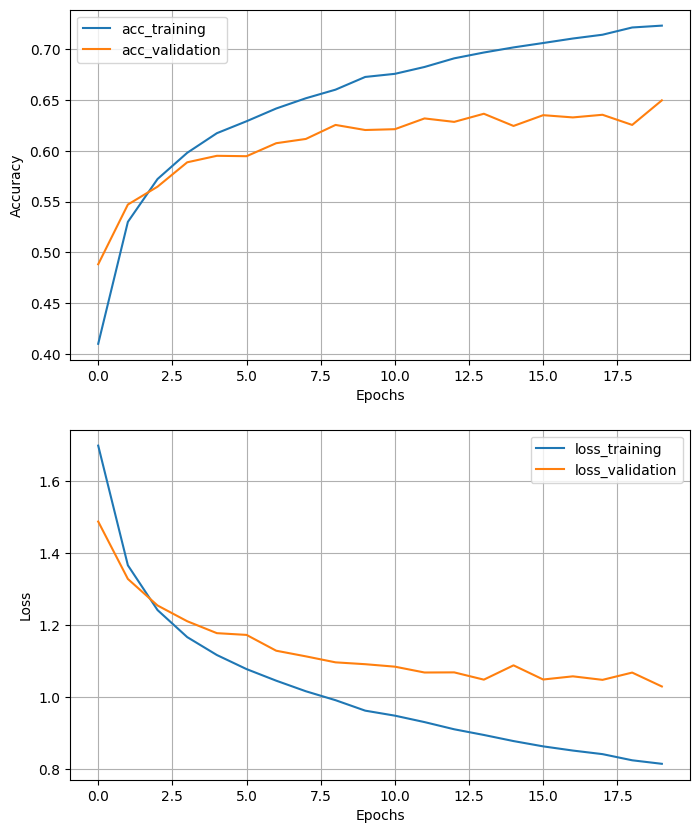

In [34]:
plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

In [35]:
def test(model, dataloader_test=dataloader_test):
  model.eval()
  total_acc_test, total_count_test, n_batches_test, loss = 0, 0, 0, 0
  for idx, (img, label) in enumerate(dataloader_test):
      img, label = img.to(device), label.to(device)
      logits = model(img)
      loss += criterion(logits, label)
      total_acc_test += (logits.argmax(1) == label).sum().item()
      total_count_test += label.size(0)
      n_batches_test += 1
  accuracy_test = total_acc_test/total_count_test
  loss_test = loss/n_batches_test
  print(f"Test Loss: {loss_test:.8f}", end=' ---------- ')
  print(f"Test Accuracy: {100*accuracy_test:.4f}%")

In [36]:
test(model)

Test Loss: 1.02028310 ---------- Test Accuracy: 65.0900%


In [37]:
layer_names = []
weights = {}
for name, param in model.named_parameters():
    if param.requires_grad:
        layer_names.append(name)
        weights.setdefault(name, param.data)

conv_weights = weights['conv_layers.0.weight']
print(f"{conv_weights.shape=} <=> [out_dim, inp_dim, kernel_size[0], kernel_size[1]]")

conv_weights.shape=torch.Size([32, 3, 3, 3]) <=> [out_dim, inp_dim, kernel_size[0], kernel_size[1]]


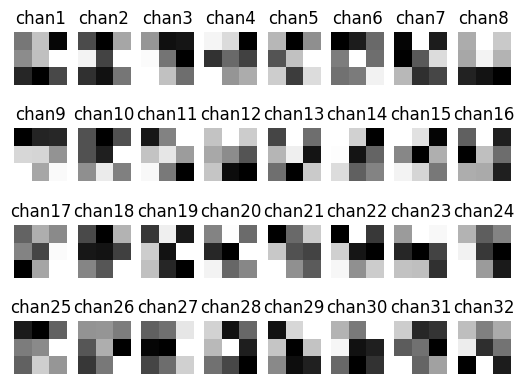

In [38]:
conv_w0 = conv_weights[:, 0, :, :] # Pick one input dimension

# Rescale weights for visualization
conv_w0 -= torch.min(conv_w0)
conv_w0 /= torch.max(conv_w0)

for r in range(4):
    for c in range(8):
        n=r*8+c
        plt.subplot(4, 8, n+1)
        plt.imshow(conv_w0[n,:,:].cpu(), interpolation='none')
        plt.title(f'chan{n+1}')
        plt.axis('off')
        plt.gray()
plt.show()

In [39]:
conv_filters = [32, 16]
kernel_sizes = [[3, 3], [2, 2]]
max_pool_sizes = [[2, 2], [2, 2]]
act_fs = [F.relu, F.relu]

num_epochs = 20
lr = 1e-3
deep_model = My_Convolutional_Network(conv_filters, kernel_sizes, max_pool_sizes,
                                      act_fs, False).to(device)
summary(deep_model, input_size=(batch_size, 3, 32, 32)) # Here is a nice summary of our model!

Layer (type:depth-idx)                   Output Shape              Param #
My_Convolutional_Network                 [256, 10]                 --
├─ModuleList: 1-3                        --                        (recursive)
│    └─Conv2d: 2-1                       [256, 32, 32, 32]         896
├─ModuleList: 1-4                        --                        --
│    └─MaxPool2d: 2-2                    [256, 32, 16, 16]         --
├─ModuleList: 1-3                        --                        (recursive)
│    └─Conv2d: 2-3                       [256, 16, 16, 16]         2,064
├─ModuleList: 1-4                        --                        --
│    └─MaxPool2d: 2-4                    [256, 16, 8, 8]           --
├─Linear: 1-5                            [256, 10]                 10,250
Total params: 13,210
Trainable params: 13,210
Non-trainable params: 0
Total mult-adds (M): 372.77
Input size (MB): 3.15
Forward/backward pass size (MB): 75.52
Params size (MB): 0.05
Estimated Total S

In [40]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(deep_model.parameters(), lr=lr)

In [41]:
start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(deep_model, optimizer, dataloader_training, dataloader_validation, epochs = num_epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Accuracy: 34.07%, Loss: 1.85276222 ---------------- Val_Acc: 43.56%, Val_Loss: 1.59132147
epoch: 2 -> Accuracy: 47.73%, Loss: 1.48563075 ---------------- Val_Acc: 49.24%, Val_Loss: 1.43299282
epoch: 3 -> Accuracy: 51.58%, Loss: 1.37662697 ---------------- Val_Acc: 52.54%, Val_Loss: 1.34967840
epoch: 4 -> Accuracy: 54.45%, Loss: 1.30620074 ---------------- Val_Acc: 53.32%, Val_Loss: 1.31724572
epoch: 5 -> Accuracy: 55.96%, Loss: 1.25806653 ---------------- Val_Acc: 55.26%, Val_Loss: 1.26804507
epoch: 6 -> Accuracy: 57.08%, Loss: 1.23062539 ---------------- Val_Acc: 55.58%, Val_Loss: 1.24595106
epoch: 7 -> Accuracy: 58.23%, Loss: 1.19801378 ---------------- Val_Acc: 55.18%, Val_Loss: 1.27833521
epoch: 8 -> Accuracy: 59.12%, Loss: 1.17473912 ---------------- Val_Acc: 57.32%, Val_Loss: 1.20413184
epoch: 9 -> Accuracy: 60.22%, Loss: 1.14483166 ---------------- Val_Acc: 57.94%, Val_Loss: 1.19281423
epoch: 10 -> Accuracy: 60.75%, Loss: 1.12576973 ---------------- Val_Acc: 58.66%, 

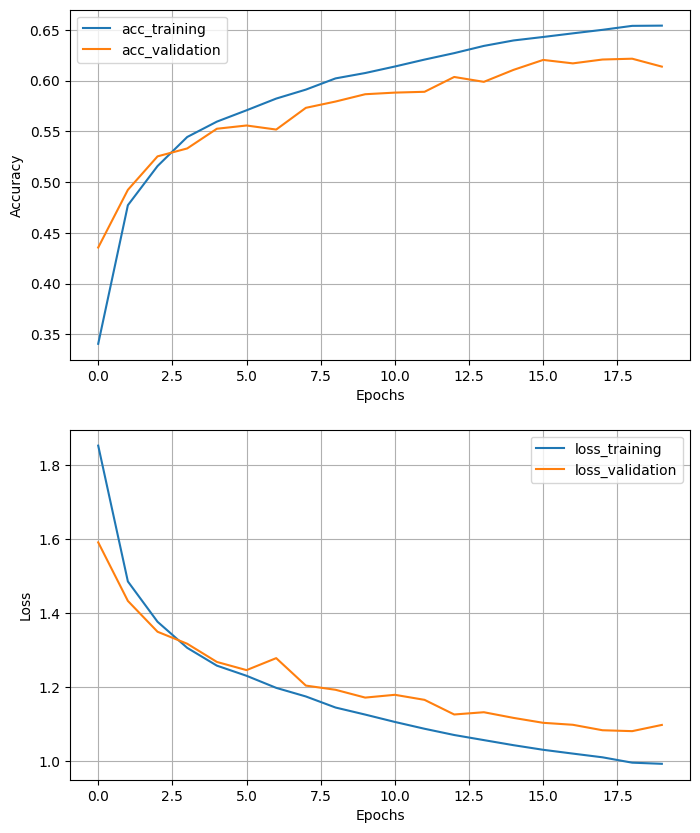

In [42]:
plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

In [43]:
test(deep_model)

Test Loss: 1.07074761 ---------- Test Accuracy: 63.0600%


epoch: 1 -> Accuracy: 42.53%, Loss: 1.61951363 ---------------- Val_Acc: 52.98%, Val_Loss: 1.33590400
epoch: 2 -> Accuracy: 57.17%, Loss: 1.22597158 ---------------- Val_Acc: 57.30%, Val_Loss: 1.19318700
epoch: 3 -> Accuracy: 61.87%, Loss: 1.09328473 ---------------- Val_Acc: 61.52%, Val_Loss: 1.09585750
epoch: 4 -> Accuracy: 65.17%, Loss: 1.00803959 ---------------- Val_Acc: 63.16%, Val_Loss: 1.05376565
epoch: 5 -> Accuracy: 67.00%, Loss: 0.95222890 ---------------- Val_Acc: 64.22%, Val_Loss: 1.03131020
epoch: 6 -> Accuracy: 69.00%, Loss: 0.89984930 ---------------- Val_Acc: 62.78%, Val_Loss: 1.04962397
epoch: 7 -> Accuracy: 70.40%, Loss: 0.85766691 ---------------- Val_Acc: 66.72%, Val_Loss: 0.95888466
epoch: 8 -> Accuracy: 71.73%, Loss: 0.82524329 ---------------- Val_Acc: 67.72%, Val_Loss: 0.93875533
epoch: 9 -> Accuracy: 73.01%, Loss: 0.79344529 ---------------- Val_Acc: 67.38%, Val_Loss: 0.94145280
epoch: 10 -> Accuracy: 73.57%, Loss: 0.76751709 ---------------- Val_Acc: 68.76%, 

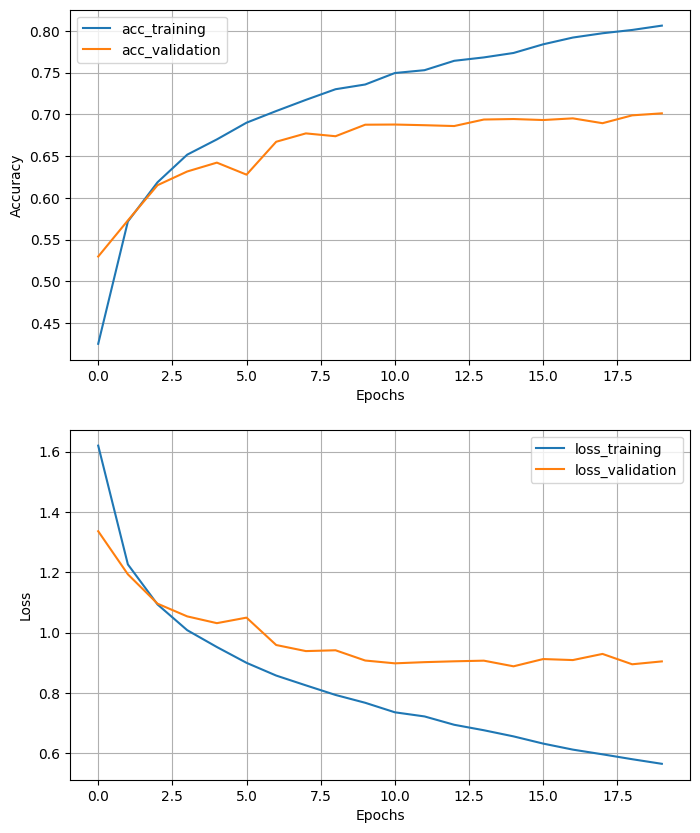

None
Test Loss: 0.89620191 ---------- Test Accuracy: 70.5600%
None


In [83]:
conv_filters = [96, 96]
kernel_sizes = [[3, 3], [2, 2]]
max_pool_sizes = [[2, 2], [2, 2]]
act_fs = [F.relu, F.relu]

num_epochs = 20
lr = 1e-3
better_model = My_Convolutional_Network(conv_filters, kernel_sizes, max_pool_sizes,
                                      act_fs, False).to(device)
summary(better_model, input_size=(batch_size, 3, 32, 32)) # Here is a nice summary of our model!

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(better_model.parameters(), lr=lr)

start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(better_model, optimizer, dataloader_training, dataloader_validation, epochs = num_epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)
test(better_model)

In [63]:
conv_filters = [32, 16]
kernel_sizes = [[3, 3], [3, 3]]
max_pool_sizes = [[2, 2], [2, 2]]
act_fs = [F.relu, F.relu]

num_epochs = 20
lr = 1e-3
better_model = My_Convolutional_Network(conv_filters, kernel_sizes, max_pool_sizes,
                                      act_fs, False).to(device)
summary(better_model, input_size=(batch_size, 3, 32, 32)) # Here is a nice summary of our model!

Layer (type:depth-idx)                   Output Shape              Param #
My_Convolutional_Network                 [256, 10]                 --
├─ModuleList: 1-3                        --                        (recursive)
│    └─Conv2d: 2-1                       [256, 32, 32, 32]         896
├─ModuleList: 1-4                        --                        --
│    └─MaxPool2d: 2-2                    [256, 32, 16, 16]         --
├─ModuleList: 1-3                        --                        (recursive)
│    └─Conv2d: 2-3                       [256, 16, 16, 16]         4,624
├─ModuleList: 1-4                        --                        --
│    └─MaxPool2d: 2-4                    [256, 16, 8, 8]           --
├─Linear: 1-5                            [256, 10]                 10,250
Total params: 15,770
Trainable params: 15,770
Non-trainable params: 0
Total mult-adds (M): 540.54
Input size (MB): 3.15
Forward/backward pass size (MB): 75.52
Params size (MB): 0.06
Estimated Total S

In [64]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(better_model.parameters(), lr=lr)

In [65]:
start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(better_model, optimizer, dataloader_training, dataloader_validation, epochs = num_epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Accuracy: 35.34%, Loss: 1.81578052 ---------------- Val_Acc: 41.18%, Val_Loss: 1.64139938
epoch: 2 -> Accuracy: 46.94%, Loss: 1.50700748 ---------------- Val_Acc: 47.20%, Val_Loss: 1.47035277
epoch: 3 -> Accuracy: 51.12%, Loss: 1.39306116 ---------------- Val_Acc: 51.32%, Val_Loss: 1.38036609
epoch: 4 -> Accuracy: 53.99%, Loss: 1.30837941 ---------------- Val_Acc: 53.84%, Val_Loss: 1.32166076
epoch: 5 -> Accuracy: 55.94%, Loss: 1.25045896 ---------------- Val_Acc: 54.70%, Val_Loss: 1.27216387
epoch: 6 -> Accuracy: 57.76%, Loss: 1.20372164 ---------------- Val_Acc: 55.28%, Val_Loss: 1.27064896
epoch: 7 -> Accuracy: 58.75%, Loss: 1.17767823 ---------------- Val_Acc: 57.70%, Val_Loss: 1.19823670
epoch: 8 -> Accuracy: 59.63%, Loss: 1.14924812 ---------------- Val_Acc: 57.42%, Val_Loss: 1.20668781
epoch: 9 -> Accuracy: 61.18%, Loss: 1.11414492 ---------------- Val_Acc: 60.14%, Val_Loss: 1.15091085
epoch: 10 -> Accuracy: 61.85%, Loss: 1.09355557 ---------------- Val_Acc: 58.62%, 

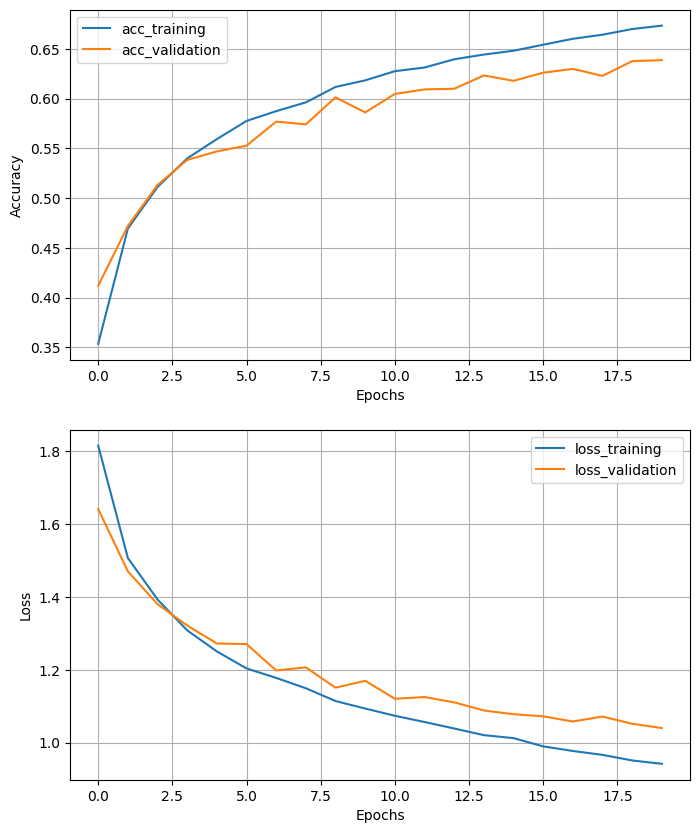

In [66]:
plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

In [67]:
test(better_model)

Test Loss: 1.01658332 ---------- Test Accuracy: 64.4200%


epoch: 1 -> Accuracy: 31.00%, Loss: 1.93630779 ---------------- Val_Acc: 38.98%, Val_Loss: 1.71093833
epoch: 2 -> Accuracy: 43.01%, Loss: 1.61862624 ---------------- Val_Acc: 44.46%, Val_Loss: 1.55893290
epoch: 3 -> Accuracy: 46.65%, Loss: 1.50901377 ---------------- Val_Acc: 46.90%, Val_Loss: 1.47710216
epoch: 4 -> Accuracy: 49.42%, Loss: 1.43910635 ---------------- Val_Acc: 50.16%, Val_Loss: 1.41717255
epoch: 5 -> Accuracy: 51.81%, Loss: 1.37770319 ---------------- Val_Acc: 52.02%, Val_Loss: 1.36787450
epoch: 6 -> Accuracy: 53.25%, Loss: 1.33437908 ---------------- Val_Acc: 53.66%, Val_Loss: 1.32633007
epoch: 7 -> Accuracy: 54.60%, Loss: 1.30155385 ---------------- Val_Acc: 53.72%, Val_Loss: 1.32071638
epoch: 8 -> Accuracy: 56.18%, Loss: 1.25937867 ---------------- Val_Acc: 55.26%, Val_Loss: 1.26355684
epoch: 9 -> Accuracy: 57.42%, Loss: 1.22704279 ---------------- Val_Acc: 56.06%, Val_Loss: 1.24250460
epoch: 10 -> Accuracy: 58.52%, Loss: 1.19887733 ---------------- Val_Acc: 57.06%, 

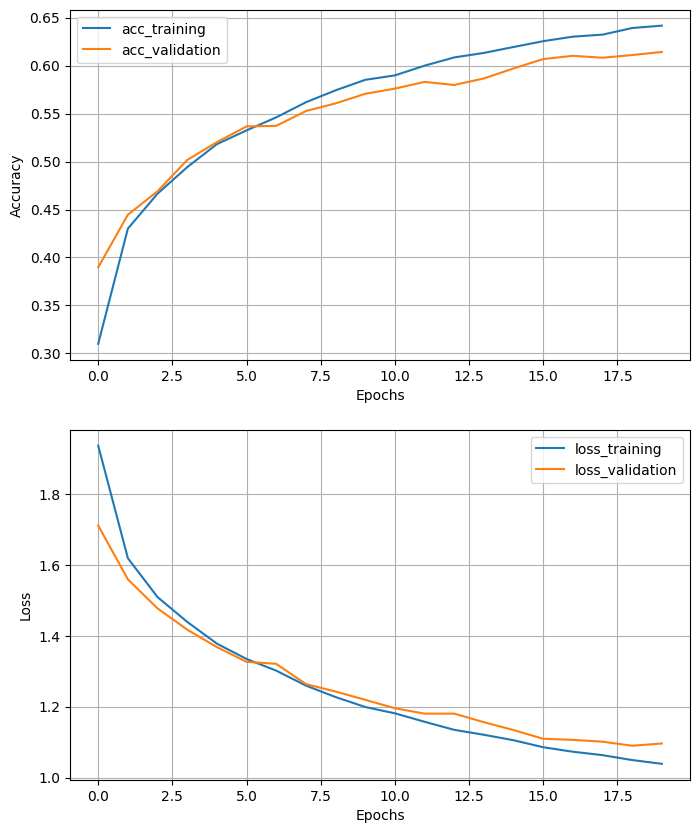

None
Test Loss: 1.07197177 ---------- Test Accuracy: 62.6500%
None


In [68]:
conv_filters = [32, 16]
kernel_sizes = [[3, 3], [2, 2]]
max_pool_sizes = [[3, 3], [2, 2]]
act_fs = [F.relu, F.relu]

num_epochs = 20
lr = 1e-3
better_model = My_Convolutional_Network(conv_filters, kernel_sizes, max_pool_sizes,
                                      act_fs, False).to(device)
summary(better_model, input_size=(batch_size, 3, 32, 32)) # Here is a nice summary of our model!

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(better_model.parameters(), lr=lr)

start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(better_model, optimizer, dataloader_training, dataloader_validation, epochs = num_epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

print(plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val))

print(test(better_model))

epoch: 1 -> Accuracy: 32.11%, Loss: 1.91946054 ---------------- Val_Acc: 38.86%, Val_Loss: 1.69029272
epoch: 2 -> Accuracy: 44.41%, Loss: 1.58117354 ---------------- Val_Acc: 44.46%, Val_Loss: 1.54347074
epoch: 3 -> Accuracy: 48.56%, Loss: 1.46052134 ---------------- Val_Acc: 47.72%, Val_Loss: 1.46205592
epoch: 4 -> Accuracy: 51.36%, Loss: 1.38625598 ---------------- Val_Acc: 51.14%, Val_Loss: 1.37779999
epoch: 5 -> Accuracy: 53.29%, Loss: 1.33173037 ---------------- Val_Acc: 52.94%, Val_Loss: 1.33756232
epoch: 6 -> Accuracy: 54.76%, Loss: 1.29768109 ---------------- Val_Acc: 53.86%, Val_Loss: 1.31104314
epoch: 7 -> Accuracy: 55.66%, Loss: 1.27197933 ---------------- Val_Acc: 53.14%, Val_Loss: 1.29997385
epoch: 8 -> Accuracy: 56.34%, Loss: 1.24688685 ---------------- Val_Acc: 55.76%, Val_Loss: 1.26000082
epoch: 9 -> Accuracy: 57.39%, Loss: 1.21900702 ---------------- Val_Acc: 56.48%, Val_Loss: 1.24363303
epoch: 10 -> Accuracy: 58.25%, Loss: 1.20305049 ---------------- Val_Acc: 57.20%, 

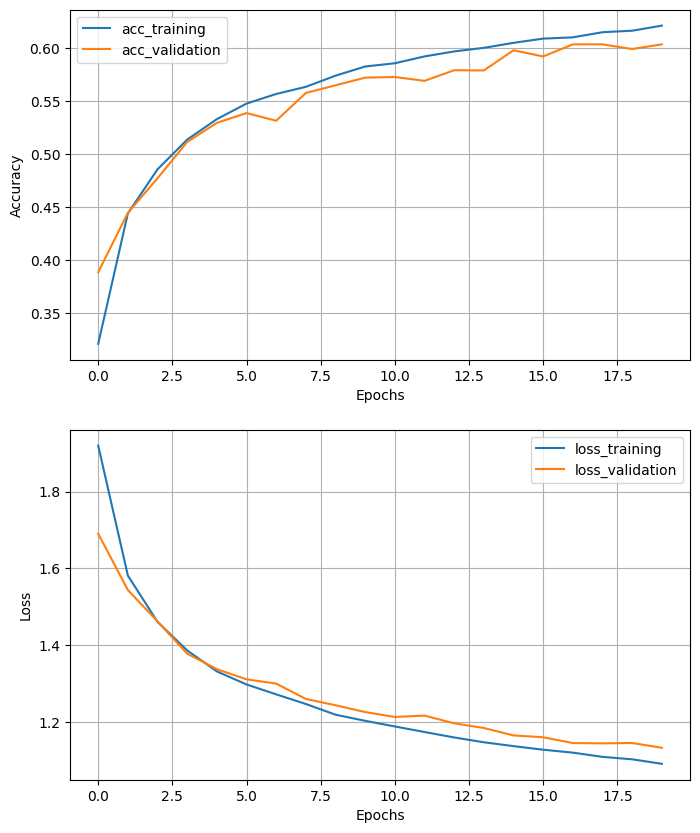

None
Test Loss: 1.13184726 ---------- Test Accuracy: 60.8400%
None


In [69]:
conv_filters = [32, 16]
kernel_sizes = [[3, 3], [2, 2]]
max_pool_sizes = [[2, 2], [3, 3]]
act_fs = [F.relu, F.relu]

num_epochs = 20
lr = 1e-3
better_model = My_Convolutional_Network(conv_filters, kernel_sizes, max_pool_sizes,
                                      act_fs, False).to(device)
summary(better_model, input_size=(batch_size, 3, 32, 32)) # Here is a nice summary of our model!

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(better_model.parameters(), lr=lr)

start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(better_model, optimizer, dataloader_training, dataloader_validation, epochs = num_epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

print(plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val))

print(test(better_model))

epoch: 1 -> Accuracy: 35.57%, Loss: 1.81811023 ---------------- Val_Acc: 44.56%, Val_Loss: 1.58023798
epoch: 2 -> Accuracy: 47.37%, Loss: 1.49211955 ---------------- Val_Acc: 47.58%, Val_Loss: 1.45392644
epoch: 3 -> Accuracy: 51.73%, Loss: 1.37402976 ---------------- Val_Acc: 51.38%, Val_Loss: 1.37665164
epoch: 4 -> Accuracy: 54.11%, Loss: 1.30609667 ---------------- Val_Acc: 52.86%, Val_Loss: 1.31596076
epoch: 5 -> Accuracy: 56.07%, Loss: 1.25735795 ---------------- Val_Acc: 54.16%, Val_Loss: 1.28783715
epoch: 6 -> Accuracy: 56.95%, Loss: 1.22307611 ---------------- Val_Acc: 54.44%, Val_Loss: 1.28536093
epoch: 7 -> Accuracy: 57.98%, Loss: 1.19910991 ---------------- Val_Acc: 57.14%, Val_Loss: 1.22425878
epoch: 8 -> Accuracy: 59.24%, Loss: 1.16186666 ---------------- Val_Acc: 58.32%, Val_Loss: 1.19165325
epoch: 9 -> Accuracy: 60.17%, Loss: 1.14071083 ---------------- Val_Acc: 57.56%, Val_Loss: 1.19636762
epoch: 10 -> Accuracy: 61.17%, Loss: 1.11127210 ---------------- Val_Acc: 59.26%, 

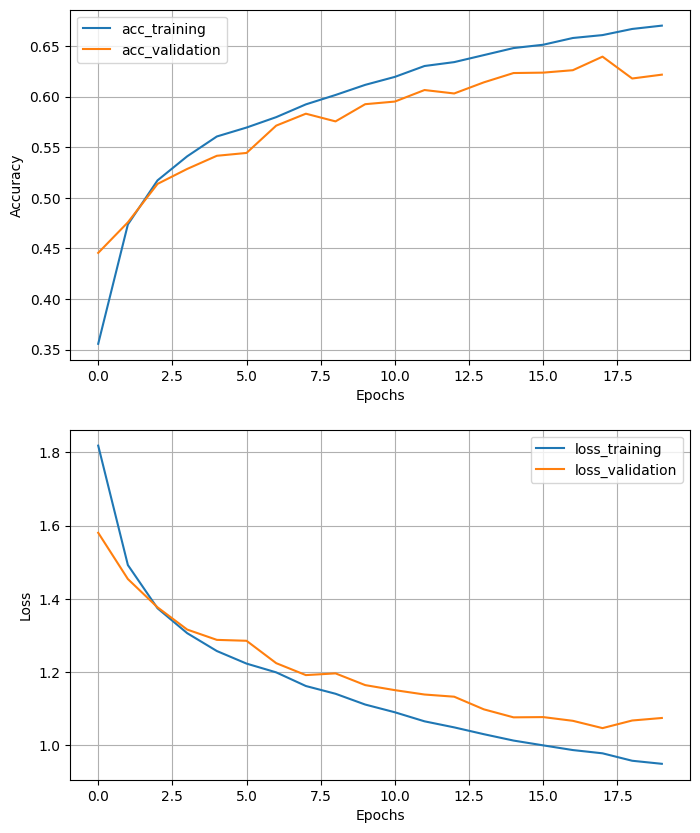

None
Test Loss: 1.06424129 ---------- Test Accuracy: 62.7900%
None


In [70]:
conv_filters = [32, 16]
kernel_sizes = [[4, 4], [2, 2]]
max_pool_sizes = [[2, 2], [2, 2]]
act_fs = [F.relu, F.relu]

num_epochs = 20
lr = 1e-3
better_model = My_Convolutional_Network(conv_filters, kernel_sizes, max_pool_sizes,
                                      act_fs, False).to(device)
summary(better_model, input_size=(batch_size, 3, 32, 32)) # Here is a nice summary of our model!

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(better_model.parameters(), lr=lr)

start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(better_model, optimizer, dataloader_training, dataloader_validation, epochs = num_epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

print(plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val))

print(test(better_model))

epoch: 1 -> Accuracy: 37.01%, Loss: 1.78554285 ---------------- Val_Acc: 45.26%, Val_Loss: 1.54654825
epoch: 2 -> Accuracy: 49.74%, Loss: 1.43183649 ---------------- Val_Acc: 51.54%, Val_Loss: 1.37625968
epoch: 3 -> Accuracy: 53.78%, Loss: 1.31983066 ---------------- Val_Acc: 54.38%, Val_Loss: 1.29444921
epoch: 4 -> Accuracy: 56.18%, Loss: 1.26100862 ---------------- Val_Acc: 55.48%, Val_Loss: 1.26326048
epoch: 5 -> Accuracy: 57.72%, Loss: 1.21348524 ---------------- Val_Acc: 56.20%, Val_Loss: 1.23714185
epoch: 6 -> Accuracy: 58.80%, Loss: 1.17546833 ---------------- Val_Acc: 56.52%, Val_Loss: 1.22521389
epoch: 7 -> Accuracy: 59.89%, Loss: 1.15200770 ---------------- Val_Acc: 57.84%, Val_Loss: 1.18914974
epoch: 8 -> Accuracy: 61.01%, Loss: 1.11780190 ---------------- Val_Acc: 60.14%, Val_Loss: 1.15296352
epoch: 9 -> Accuracy: 61.60%, Loss: 1.09567165 ---------------- Val_Acc: 60.32%, Val_Loss: 1.13180709
epoch: 10 -> Accuracy: 62.77%, Loss: 1.06204295 ---------------- Val_Acc: 60.24%, 

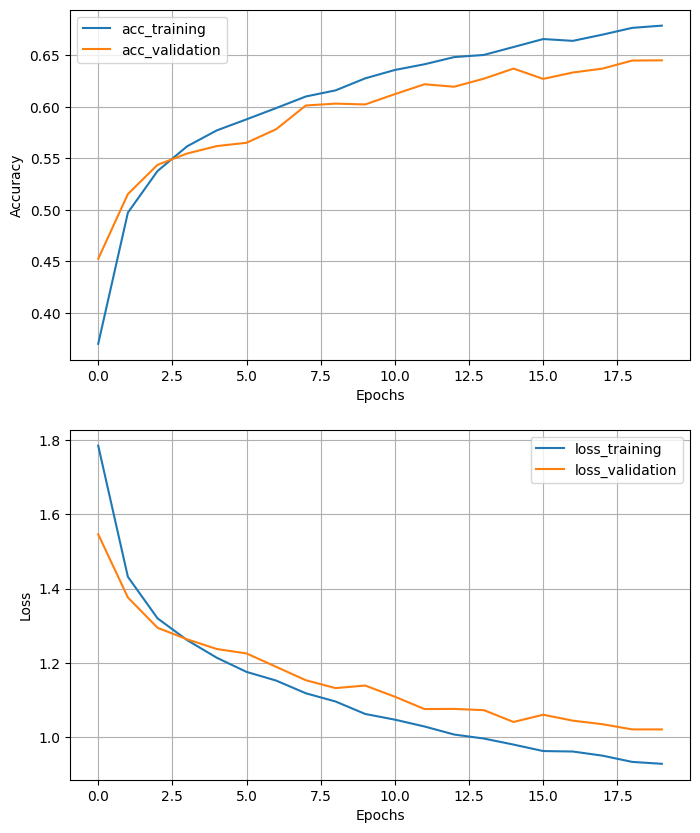

None
Test Loss: 1.00064552 ---------- Test Accuracy: 65.2300%
None


In [71]:
conv_filters = [64, 16]
kernel_sizes = [[3, 3], [2, 2]]
max_pool_sizes = [[2, 2], [2, 2]]
act_fs = [F.relu, F.relu]

num_epochs = 20
lr = 1e-3
better_model = My_Convolutional_Network(conv_filters, kernel_sizes, max_pool_sizes,
                                      act_fs, False).to(device)
summary(better_model, input_size=(batch_size, 3, 32, 32)) # Here is a nice summary of our model!

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(better_model.parameters(), lr=lr)

start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(better_model, optimizer, dataloader_training, dataloader_validation, epochs = num_epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

print(plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val))

print(test(better_model))

epoch: 1 -> Accuracy: 35.78%, Loss: 1.81230223 ---------------- Val_Acc: 44.12%, Val_Loss: 1.57850134
epoch: 2 -> Accuracy: 49.68%, Loss: 1.43495476 ---------------- Val_Acc: 51.00%, Val_Loss: 1.37336588
epoch: 3 -> Accuracy: 54.82%, Loss: 1.29542363 ---------------- Val_Acc: 54.74%, Val_Loss: 1.27381718
epoch: 4 -> Accuracy: 57.32%, Loss: 1.22520435 ---------------- Val_Acc: 55.92%, Val_Loss: 1.23123097
epoch: 5 -> Accuracy: 59.46%, Loss: 1.17180657 ---------------- Val_Acc: 58.42%, Val_Loss: 1.19224346
epoch: 6 -> Accuracy: 61.00%, Loss: 1.12810826 ---------------- Val_Acc: 58.88%, Val_Loss: 1.17744923
epoch: 7 -> Accuracy: 62.30%, Loss: 1.09633923 ---------------- Val_Acc: 60.80%, Val_Loss: 1.13377750
epoch: 8 -> Accuracy: 63.44%, Loss: 1.06243789 ---------------- Val_Acc: 60.94%, Val_Loss: 1.11891794
epoch: 9 -> Accuracy: 64.44%, Loss: 1.03590965 ---------------- Val_Acc: 61.46%, Val_Loss: 1.10317791
epoch: 10 -> Accuracy: 65.17%, Loss: 1.01522255 ---------------- Val_Acc: 61.70%, 

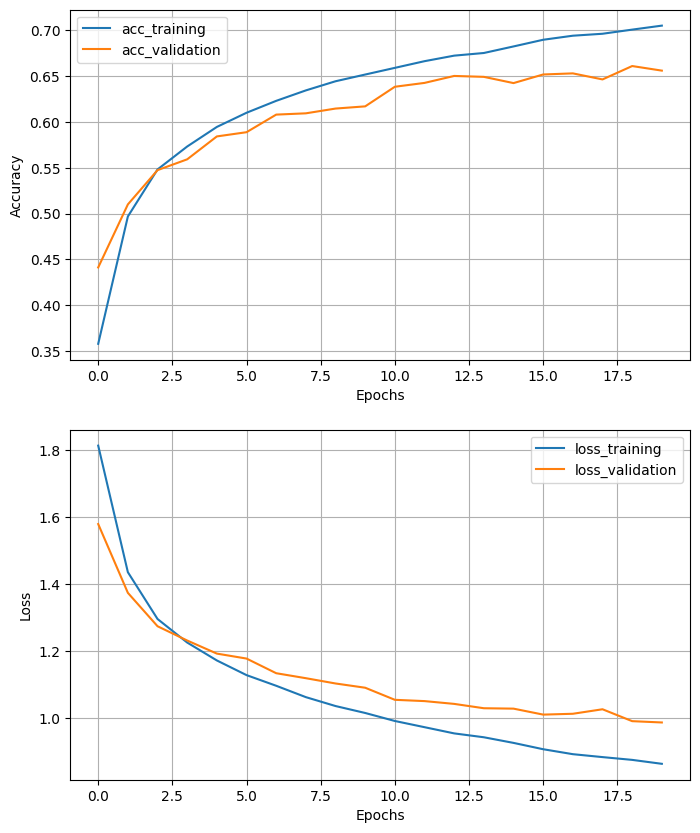

None
Test Loss: 0.96724540 ---------- Test Accuracy: 66.9300%
None


In [72]:
conv_filters = [32, 32]
kernel_sizes = [[3, 3], [2, 2]]
max_pool_sizes = [[2, 2], [2, 2]]
act_fs = [F.relu, F.relu]

num_epochs = 20
lr = 1e-3
better_model = My_Convolutional_Network(conv_filters, kernel_sizes, max_pool_sizes,
                                      act_fs, False).to(device)
summary(better_model, input_size=(batch_size, 3, 32, 32)) # Here is a nice summary of our model!

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(better_model.parameters(), lr=lr)

start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(better_model, optimizer, dataloader_training, dataloader_validation, epochs = num_epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

print(plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val))

print(test(better_model))

epoch: 1 -> Accuracy: 42.63%, Loss: 1.62453103 ---------------- Val_Acc: 51.36%, Val_Loss: 1.37368619
epoch: 2 -> Accuracy: 55.82%, Loss: 1.26052117 ---------------- Val_Acc: 57.40%, Val_Loss: 1.23131967
epoch: 3 -> Accuracy: 60.75%, Loss: 1.13089371 ---------------- Val_Acc: 61.20%, Val_Loss: 1.11078966
epoch: 4 -> Accuracy: 63.67%, Loss: 1.04646492 ---------------- Val_Acc: 62.46%, Val_Loss: 1.07029688
epoch: 5 -> Accuracy: 66.12%, Loss: 0.97838509 ---------------- Val_Acc: 63.96%, Val_Loss: 1.04518330
epoch: 6 -> Accuracy: 67.84%, Loss: 0.93272698 ---------------- Val_Acc: 65.90%, Val_Loss: 0.98201495
epoch: 7 -> Accuracy: 69.40%, Loss: 0.88502157 ---------------- Val_Acc: 66.60%, Val_Loss: 0.96494168
epoch: 8 -> Accuracy: 70.29%, Loss: 0.85850805 ---------------- Val_Acc: 67.76%, Val_Loss: 0.93560880
epoch: 9 -> Accuracy: 71.66%, Loss: 0.82315880 ---------------- Val_Acc: 67.86%, Val_Loss: 0.92213166
epoch: 10 -> Accuracy: 72.63%, Loss: 0.79616082 ---------------- Val_Acc: 67.64%, 

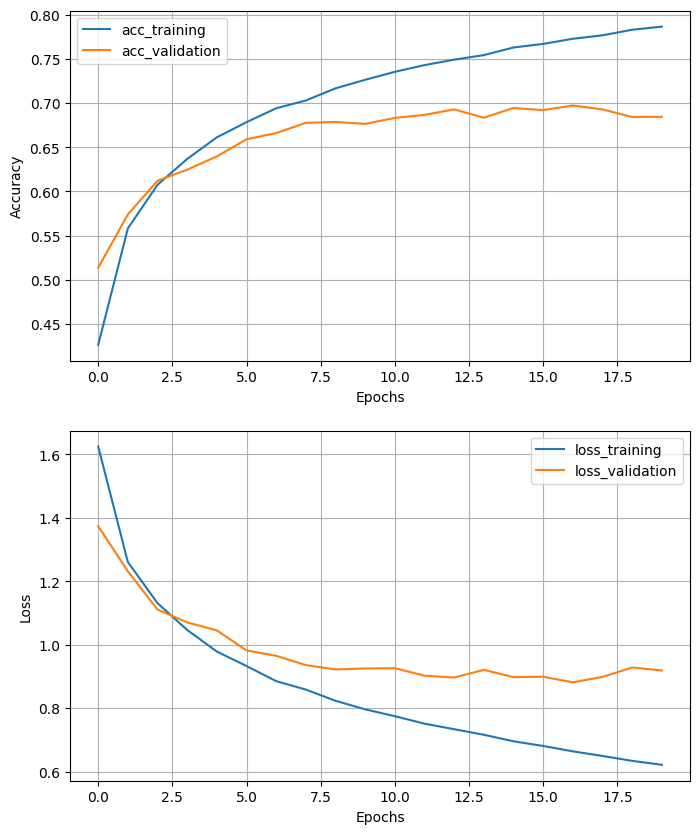

None
Test Loss: 0.89326811 ---------- Test Accuracy: 69.5600%
None


In [73]:
conv_filters = [64, 64]
kernel_sizes = [[3, 3], [3, 3]]
max_pool_sizes = [[2, 2], [2, 2]]
act_fs = [F.relu, F.relu]

num_epochs = 20
lr = 1e-3
better_model = My_Convolutional_Network(conv_filters, kernel_sizes, max_pool_sizes,
                                      act_fs, False).to(device)
summary(better_model, input_size=(batch_size, 3, 32, 32)) # Here is a nice summary of our model!

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(better_model.parameters(), lr=lr)

start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(better_model, optimizer, dataloader_training, dataloader_validation, epochs = num_epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

print(plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val))

print(test(better_model))

epoch: 1 -> Accuracy: 34.66%, Loss: 1.84918320 ---------------- Val_Acc: 43.86%, Val_Loss: 1.59913576
epoch: 2 -> Accuracy: 47.39%, Loss: 1.49170876 ---------------- Val_Acc: 48.56%, Val_Loss: 1.43946016
epoch: 3 -> Accuracy: 51.93%, Loss: 1.36714971 ---------------- Val_Acc: 51.08%, Val_Loss: 1.35860717
epoch: 4 -> Accuracy: 54.24%, Loss: 1.30383325 ---------------- Val_Acc: 54.02%, Val_Loss: 1.30342710
epoch: 5 -> Accuracy: 56.35%, Loss: 1.25374520 ---------------- Val_Acc: 55.60%, Val_Loss: 1.27549553
epoch: 6 -> Accuracy: 57.33%, Loss: 1.21707082 ---------------- Val_Acc: 56.30%, Val_Loss: 1.23938644
epoch: 7 -> Accuracy: 58.50%, Loss: 1.18386948 ---------------- Val_Acc: 57.40%, Val_Loss: 1.21467197
epoch: 8 -> Accuracy: 59.54%, Loss: 1.15591323 ---------------- Val_Acc: 57.22%, Val_Loss: 1.20031905
epoch: 9 -> Accuracy: 60.35%, Loss: 1.13577724 ---------------- Val_Acc: 58.74%, Val_Loss: 1.18337953
epoch: 10 -> Accuracy: 61.18%, Loss: 1.11431754 ---------------- Val_Acc: 58.86%, 

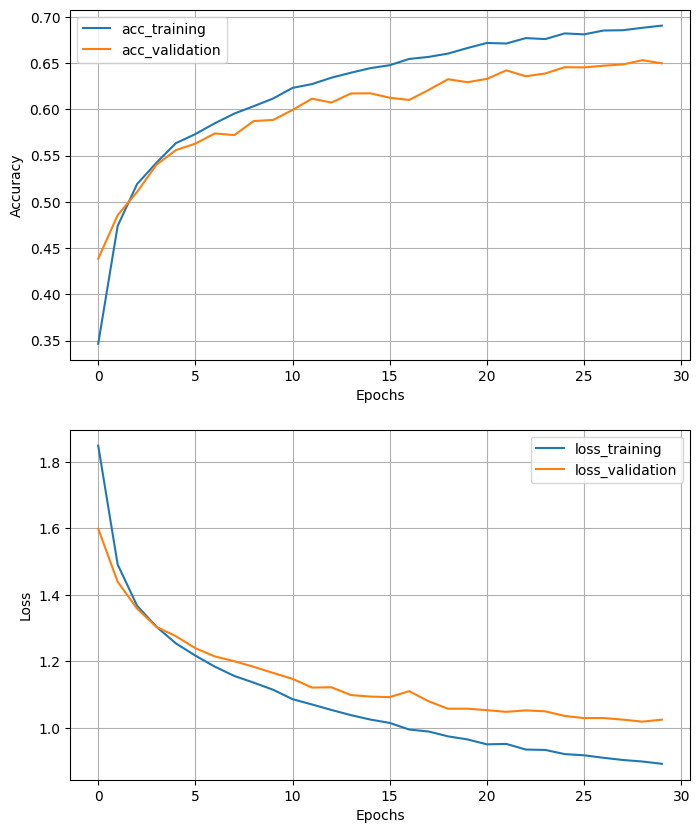

None
Test Loss: 1.00240171 ---------- Test Accuracy: 65.3500%
None


In [86]:
conv_filters = [32, 16]
kernel_sizes = [[3, 3], [2, 2]]
max_pool_sizes = [[2, 2], [2, 2]]
act_fs = [F.relu, F.relu]

num_epochs = 30
lr = 1e-3
better_model = My_Convolutional_Network(conv_filters, kernel_sizes, max_pool_sizes,
                                      act_fs, False).to(device)
summary(better_model, input_size=(batch_size, 3, 32, 32)) # Here is a nice summary of our model!

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(better_model.parameters(), lr=lr)

start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(better_model, optimizer, dataloader_training, dataloader_validation, epochs = num_epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

print(plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val))

print(test(better_model))

epoch: 1 -> Accuracy: 13.63%, Loss: 2.28287172 ---------------- Val_Acc: 24.16%, Val_Loss: 2.14557195
epoch: 2 -> Accuracy: 28.76%, Loss: 2.00886655 ---------------- Val_Acc: 28.36%, Val_Loss: 1.96109760
epoch: 3 -> Accuracy: 34.27%, Loss: 1.86141181 ---------------- Val_Acc: 33.60%, Val_Loss: 1.84461081
epoch: 4 -> Accuracy: 37.14%, Loss: 1.78579712 ---------------- Val_Acc: 37.26%, Val_Loss: 1.78154755
epoch: 5 -> Accuracy: 38.86%, Loss: 1.74118340 ---------------- Val_Acc: 37.98%, Val_Loss: 1.73844135
epoch: 6 -> Accuracy: 40.48%, Loss: 1.69511139 ---------------- Val_Acc: 39.62%, Val_Loss: 1.70108545
epoch: 7 -> Accuracy: 41.84%, Loss: 1.65727615 ---------------- Val_Acc: 40.32%, Val_Loss: 1.66503942
epoch: 8 -> Accuracy: 43.18%, Loss: 1.62370217 ---------------- Val_Acc: 41.96%, Val_Loss: 1.62248957
epoch: 9 -> Accuracy: 43.91%, Loss: 1.59517503 ---------------- Val_Acc: 43.28%, Val_Loss: 1.60072803
epoch: 10 -> Accuracy: 44.49%, Loss: 1.57413852 ---------------- Val_Acc: 42.74%, 

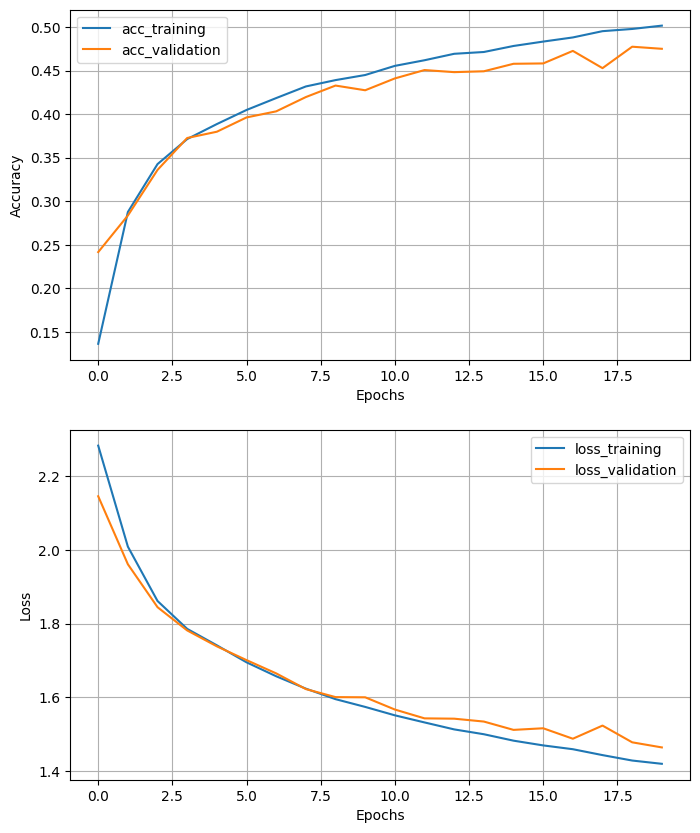

None
Test Loss: 1.42729509 ---------- Test Accuracy: 49.4800%
None


In [76]:
conv_filters = [32, 16]
kernel_sizes = [[3, 3], [2, 2]]
max_pool_sizes = [[2, 2], [2, 2]]
act_fs = [F.sigmoid, F.sigmoid]

num_epochs = 20
lr = 1e-3
better_model = My_Convolutional_Network(conv_filters, kernel_sizes, max_pool_sizes,
                                      act_fs, False).to(device)
summary(better_model, input_size=(batch_size, 3, 32, 32)) # Here is a nice summary of our model!

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(better_model.parameters(), lr=lr)

start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(better_model, optimizer, dataloader_training, dataloader_validation, epochs = num_epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

print(plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val))

print(test(better_model))

epoch: 1 -> Accuracy: 37.14%, Loss: 1.79541695 ---------------- Val_Acc: 44.06%, Val_Loss: 1.58746064
epoch: 2 -> Accuracy: 48.06%, Loss: 1.48447037 ---------------- Val_Acc: 49.16%, Val_Loss: 1.43279994
epoch: 3 -> Accuracy: 53.11%, Loss: 1.35110664 ---------------- Val_Acc: 54.00%, Val_Loss: 1.31603515
epoch: 4 -> Accuracy: 56.23%, Loss: 1.26345372 ---------------- Val_Acc: 55.06%, Val_Loss: 1.26845586
epoch: 5 -> Accuracy: 58.26%, Loss: 1.21000171 ---------------- Val_Acc: 56.58%, Val_Loss: 1.23135328
epoch: 6 -> Accuracy: 59.81%, Loss: 1.16836739 ---------------- Val_Acc: 58.28%, Val_Loss: 1.19524360
epoch: 7 -> Accuracy: 60.75%, Loss: 1.13293362 ---------------- Val_Acc: 59.44%, Val_Loss: 1.16617072
epoch: 8 -> Accuracy: 62.00%, Loss: 1.10104883 ---------------- Val_Acc: 59.78%, Val_Loss: 1.15189171
epoch: 9 -> Accuracy: 62.92%, Loss: 1.07811797 ---------------- Val_Acc: 59.78%, Val_Loss: 1.13606894
epoch: 10 -> Accuracy: 63.31%, Loss: 1.06503177 ---------------- Val_Acc: 60.54%, 

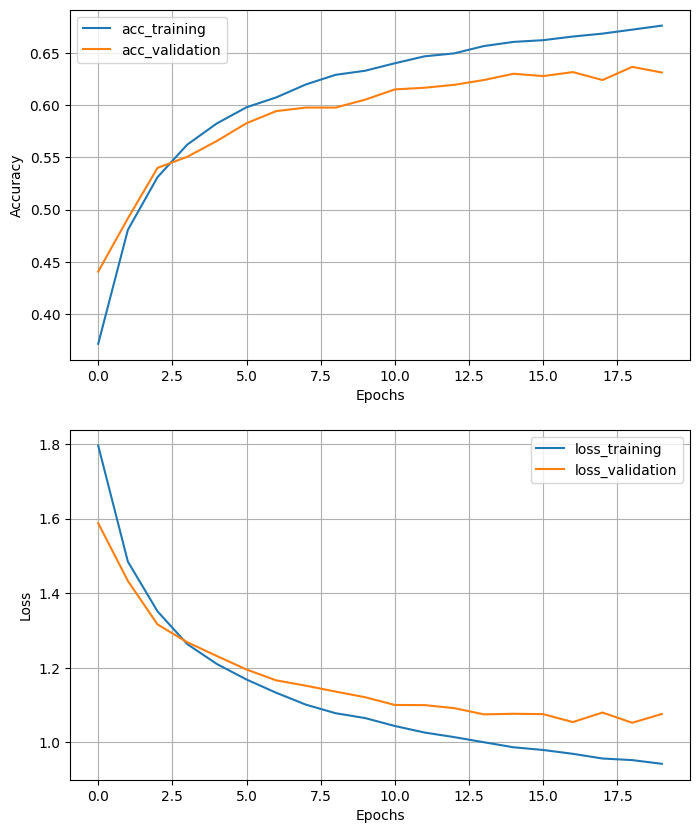

None
Test Loss: 1.06460750 ---------- Test Accuracy: 63.3500%
None


In [77]:
conv_filters = [32, 16]
kernel_sizes = [[3, 3], [2, 2]]
max_pool_sizes = [[2, 2], [2, 2]]
act_fs = [F.elu, F.elu]

num_epochs = 20
lr = 1e-3
better_model = My_Convolutional_Network(conv_filters, kernel_sizes, max_pool_sizes,
                                      act_fs, False).to(device)
summary(better_model, input_size=(batch_size, 3, 32, 32)) # Here is a nice summary of our model!

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(better_model.parameters(), lr=lr)

start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(better_model, optimizer, dataloader_training, dataloader_validation, epochs = num_epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

print(plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val))

print(test(better_model))

epoch: 1 -> Accuracy: 13.03%, Loss: 2.28696370 ---------------- Val_Acc: 21.08%, Val_Loss: 2.18340468
epoch: 2 -> Accuracy: 26.65%, Loss: 2.04691815 ---------------- Val_Acc: 28.24%, Val_Loss: 1.99431837
epoch: 3 -> Accuracy: 30.54%, Loss: 1.94473684 ---------------- Val_Acc: 32.40%, Val_Loss: 1.89761889
epoch: 4 -> Accuracy: 35.79%, Loss: 1.82028770 ---------------- Val_Acc: 36.36%, Val_Loss: 1.77952349
epoch: 5 -> Accuracy: 39.07%, Loss: 1.72743905 ---------------- Val_Acc: 39.54%, Val_Loss: 1.70707989
epoch: 6 -> Accuracy: 41.07%, Loss: 1.67090249 ---------------- Val_Acc: 40.58%, Val_Loss: 1.66609275
epoch: 7 -> Accuracy: 42.61%, Loss: 1.63162065 ---------------- Val_Acc: 41.98%, Val_Loss: 1.62793922
epoch: 8 -> Accuracy: 43.72%, Loss: 1.59731400 ---------------- Val_Acc: 43.30%, Val_Loss: 1.60081851
epoch: 9 -> Accuracy: 44.59%, Loss: 1.56931496 ---------------- Val_Acc: 44.86%, Val_Loss: 1.56812692
epoch: 10 -> Accuracy: 45.65%, Loss: 1.54321826 ---------------- Val_Acc: 45.40%, 

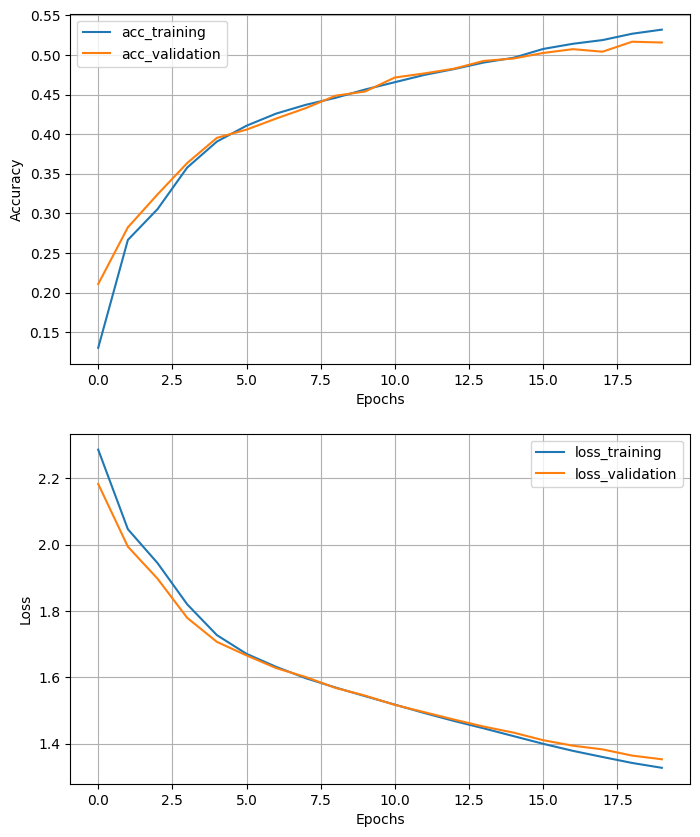

None
Test Loss: 1.33931386 ---------- Test Accuracy: 52.5400%
None


In [78]:
conv_filters = [32, 16]
kernel_sizes = [[3, 3], [2, 2]]
max_pool_sizes = [[2, 2], [2, 2]]
act_fs = [F.softmax, F.softmax]

num_epochs = 20
lr = 1e-3
better_model = My_Convolutional_Network(conv_filters, kernel_sizes, max_pool_sizes,
                                      act_fs, False).to(device)
summary(better_model, input_size=(batch_size, 3, 32, 32)) # Here is a nice summary of our model!

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(better_model.parameters(), lr=lr)

start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(better_model, optimizer, dataloader_training, dataloader_validation, epochs = num_epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

print(plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val))

print(test(better_model))

epoch: 1 -> Accuracy: 35.62%, Loss: 1.83843529 ---------------- Val_Acc: 43.84%, Val_Loss: 1.59665751
epoch: 2 -> Accuracy: 47.46%, Loss: 1.50433505 ---------------- Val_Acc: 48.18%, Val_Loss: 1.46349907
epoch: 3 -> Accuracy: 50.96%, Loss: 1.39799750 ---------------- Val_Acc: 51.22%, Val_Loss: 1.38313103
epoch: 4 -> Accuracy: 53.60%, Loss: 1.32808506 ---------------- Val_Acc: 52.60%, Val_Loss: 1.33454192
epoch: 5 -> Accuracy: 55.02%, Loss: 1.28025818 ---------------- Val_Acc: 55.08%, Val_Loss: 1.28688383
epoch: 6 -> Accuracy: 56.50%, Loss: 1.24056947 ---------------- Val_Acc: 56.12%, Val_Loss: 1.25100601
epoch: 7 -> Accuracy: 57.89%, Loss: 1.20597196 ---------------- Val_Acc: 56.80%, Val_Loss: 1.22967958
epoch: 8 -> Accuracy: 58.65%, Loss: 1.17894316 ---------------- Val_Acc: 56.94%, Val_Loss: 1.21979594
epoch: 9 -> Accuracy: 59.75%, Loss: 1.15449679 ---------------- Val_Acc: 57.78%, Val_Loss: 1.20759416
epoch: 10 -> Accuracy: 60.38%, Loss: 1.13412213 ---------------- Val_Acc: 58.50%, 

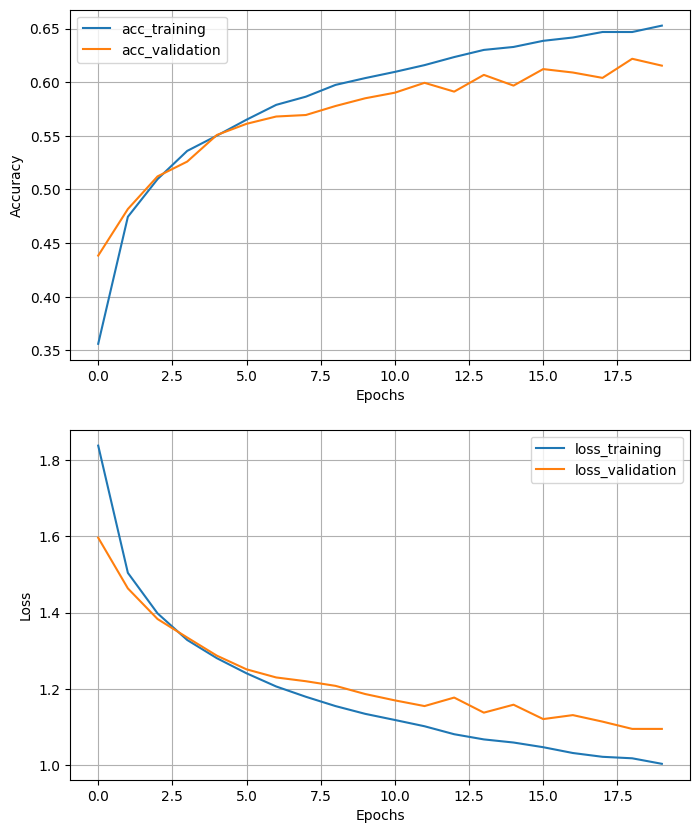

None
Test Loss: 1.07451022 ---------- Test Accuracy: 62.7100%
None


In [79]:
conv_filters = [32, 16]
kernel_sizes = [[3, 3], [2, 2]]
max_pool_sizes = [[2, 2], [2, 2]]
act_fs = [F.leaky_relu, F.leaky_relu]

num_epochs = 20
lr = 1e-3
better_model = My_Convolutional_Network(conv_filters, kernel_sizes, max_pool_sizes,
                                      act_fs, False).to(device)
summary(better_model, input_size=(batch_size, 3, 32, 32)) # Here is a nice summary of our model!

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(better_model.parameters(), lr=lr)

start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(better_model, optimizer, dataloader_training, dataloader_validation, epochs = num_epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

print(plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val))

print(test(better_model))

epoch: 1 -> Accuracy: 17.51%, Loss: 2.20073199 ---------------- Val_Acc: 27.82%, Val_Loss: 2.00676656
epoch: 2 -> Accuracy: 33.50%, Loss: 1.87965775 ---------------- Val_Acc: 36.30%, Val_Loss: 1.81105959
epoch: 3 -> Accuracy: 37.99%, Loss: 1.76674461 ---------------- Val_Acc: 37.86%, Val_Loss: 1.75644910
epoch: 4 -> Accuracy: 40.10%, Loss: 1.71781325 ---------------- Val_Acc: 39.00%, Val_Loss: 1.72885740
epoch: 5 -> Accuracy: 41.15%, Loss: 1.68398201 ---------------- Val_Acc: 39.60%, Val_Loss: 1.69534719
epoch: 6 -> Accuracy: 42.33%, Loss: 1.65232062 ---------------- Val_Acc: 40.22%, Val_Loss: 1.68007815
epoch: 7 -> Accuracy: 43.84%, Loss: 1.61455822 ---------------- Val_Acc: 41.88%, Val_Loss: 1.64231718
epoch: 8 -> Accuracy: 45.20%, Loss: 1.57460320 ---------------- Val_Acc: 44.02%, Val_Loss: 1.57971382
epoch: 9 -> Accuracy: 46.25%, Loss: 1.54214668 ---------------- Val_Acc: 44.60%, Val_Loss: 1.56326854
epoch: 10 -> Accuracy: 47.29%, Loss: 1.51748419 ---------------- Val_Acc: 45.22%, 

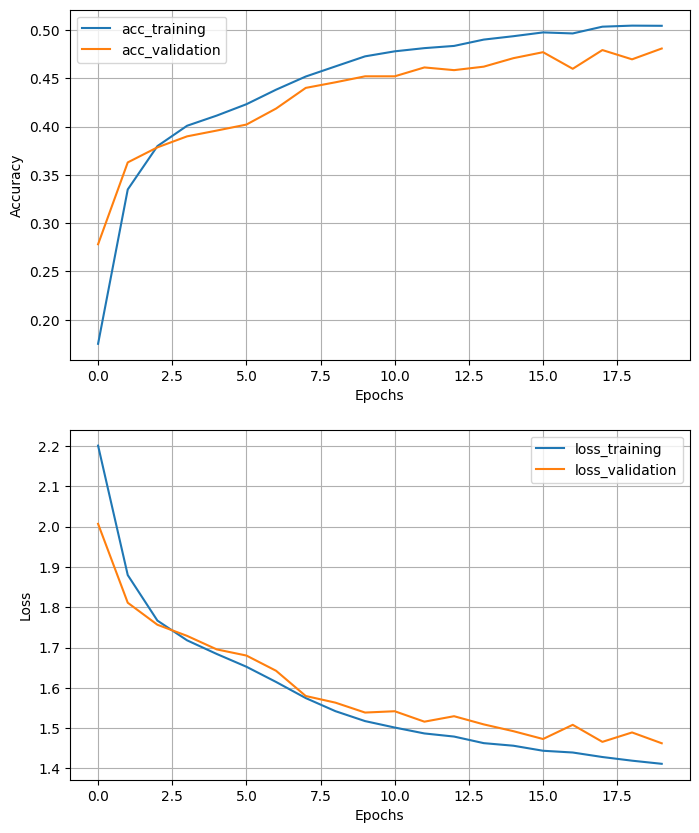

None
Test Loss: 1.43526208 ---------- Test Accuracy: 49.8200%
None


In [80]:
conv_filters = [32, 16]
kernel_sizes = [[3, 3], [2, 2]]
max_pool_sizes = [[2, 2], [2, 2]]
act_fs = [F.logsigmoid, F.logsigmoid]

num_epochs = 20
lr = 1e-3
better_model = My_Convolutional_Network(conv_filters, kernel_sizes, max_pool_sizes,
                                      act_fs, False).to(device)
summary(better_model, input_size=(batch_size, 3, 32, 32)) # Here is a nice summary of our model!

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(better_model.parameters(), lr=lr)

start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(better_model, optimizer, dataloader_training, dataloader_validation, epochs = num_epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

print(plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val))

print(test(better_model))

epoch: 1 -> Accuracy: 44.04%, Loss: 1.57754803 ---------------- Val_Acc: 52.78%, Val_Loss: 1.35229242
epoch: 2 -> Accuracy: 57.56%, Loss: 1.21524692 ---------------- Val_Acc: 59.08%, Val_Loss: 1.17157769
epoch: 3 -> Accuracy: 62.65%, Loss: 1.07887971 ---------------- Val_Acc: 62.68%, Val_Loss: 1.06834614
epoch: 4 -> Accuracy: 65.28%, Loss: 0.99968308 ---------------- Val_Acc: 63.48%, Val_Loss: 1.04174697
epoch: 5 -> Accuracy: 67.72%, Loss: 0.93653733 ---------------- Val_Acc: 64.16%, Val_Loss: 1.02034771
epoch: 6 -> Accuracy: 69.40%, Loss: 0.88218397 ---------------- Val_Acc: 66.34%, Val_Loss: 0.96470577
epoch: 7 -> Accuracy: 70.83%, Loss: 0.84203446 ---------------- Val_Acc: 67.36%, Val_Loss: 0.93906164
epoch: 8 -> Accuracy: 72.78%, Loss: 0.79697889 ---------------- Val_Acc: 68.12%, Val_Loss: 0.92685711
epoch: 9 -> Accuracy: 73.55%, Loss: 0.77311009 ---------------- Val_Acc: 68.74%, Val_Loss: 0.91677821
epoch: 10 -> Accuracy: 74.54%, Loss: 0.74294603 ---------------- Val_Acc: 68.20%, 

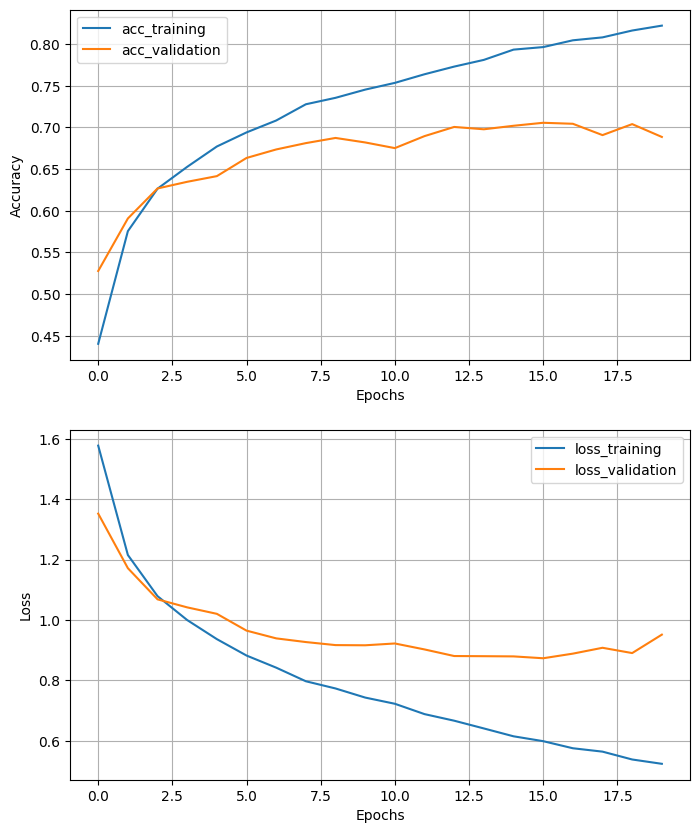

None
Test Loss: 0.95133966 ---------- Test Accuracy: 69.2800%
None


In [81]:
conv_filters = [128, 128]
kernel_sizes = [[3, 3], [2, 2]]
max_pool_sizes = [[2, 2], [2, 2]]
act_fs = [F.relu, F.relu]

num_epochs = 20
lr = 1e-3
better_model = My_Convolutional_Network(conv_filters, kernel_sizes, max_pool_sizes,
                                      act_fs, False).to(device)
summary(better_model, input_size=(batch_size, 3, 32, 32)) # Here is a nice summary of our model!

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(better_model.parameters(), lr=lr)

start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(better_model, optimizer, dataloader_training, dataloader_validation, epochs = num_epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

print(plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val))

print(test(better_model))

In [87]:
from torchvision.models import resnet18, ResNet18_Weights

In [88]:
RESNET18 = resnet18(pretrained=True)
summary(RESNET18, input_size=(batch_size, 3, 32, 32))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\elnur/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [256, 1000]               --
├─Conv2d: 1-1                            [256, 64, 16, 16]         9,408
├─BatchNorm2d: 1-2                       [256, 64, 16, 16]         128
├─ReLU: 1-3                              [256, 64, 16, 16]         --
├─MaxPool2d: 1-4                         [256, 64, 8, 8]           --
├─Sequential: 1-5                        [256, 64, 8, 8]           --
│    └─BasicBlock: 2-1                   [256, 64, 8, 8]           --
│    │    └─Conv2d: 3-1                  [256, 64, 8, 8]           36,864
│    │    └─BatchNorm2d: 3-2             [256, 64, 8, 8]           128
│    │    └─ReLU: 3-3                    [256, 64, 8, 8]           --
│    │    └─Conv2d: 3-4                  [256, 64, 8, 8]           36,864
│    │    └─BatchNorm2d: 3-5             [256, 64, 8, 8]           128
│    │    └─ReLU: 3-6                    [256, 64, 8, 8]           --
│

In [89]:
linear_layer_input = RESNET18.fc.in_features
linear_layer_output = RESNET18.fc.out_features
print(f"Last layer: {linear_layer_input} -> {linear_layer_output}")

Last layer: 512 -> 1000


In [90]:
# Replace  the last layer
RESNET18.fc = Linear(linear_layer_input, 10)

In [91]:
linear_layer_input = RESNET18.fc.in_features
linear_layer_output = RESNET18.fc.out_features
print(f"Last layer: {linear_layer_input} -> {linear_layer_output}")

Last layer: 512 -> 10


In [92]:
for name, param in RESNET18.named_parameters():
    if name == 'fc.weight' or name == 'fc.bias':
      param.requires_grad = True
    else:
      param.requires_grad = False

In [93]:
RESNET18 = RESNET18.to(device) # Let's now load it to GPU

In [94]:
train_idxs = list(range(0, len(train_data), 5))  # 45000/5=9000 Tr
val_idxs = list(range(1, len(val_data), 5))  # 5000/5=1000 Val
test_idxs = list(range(1, len(test_data), 5))  # 10000/5=2000 Ts

train_data_sub = torch.utils.data.Subset(train_data, train_idxs)
val_data_sub = torch.utils.data.Subset(val_data, val_idxs)
test_data_sub = torch.utils.data.Subset(test_data, test_idxs)

In [95]:
weights = ResNet18_Weights.DEFAULT
preprocess = weights.transforms()

class RESDatasetWrapper(Dataset):
  def __init__(self, dataset):
    self.dataset = dataset
  def __len__(self):
    return len(self.dataset)
  def __getitem__(self, idx):
    image, label = self.dataset[idx]
    image = preprocess(image)
    label = torch.tensor(label, dtype=torch.long)
    return image.to(device), label.to(device)

In [96]:
RES_train_dataset = RESDatasetWrapper(train_data_sub)
RES_val_dataset = RESDatasetWrapper(val_data_sub)
RES_test_dataset = RESDatasetWrapper(test_data_sub)

batch_size=256

RES_dataloader_training = DataLoader(RES_train_dataset, batch_size=batch_size, shuffle=True)
RES_dataloader_validation = DataLoader(RES_val_dataset, batch_size=batch_size)
RES_dataloader_test = DataLoader(RES_test_dataset, batch_size=batch_size)

In [97]:
num_epochs = 10
lr = 1e-3

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(RESNET18.parameters(), lr=lr)

In [98]:
start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(RESNET18, optimizer,
                                                           RES_dataloader_training, 
                                                           RES_dataloader_validation,
                                                           epochs = num_epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Accuracy: 36.76%, Loss: 1.87803233 ---------------- Val_Acc: 59.90%, Val_Loss: 1.40397072
epoch: 2 -> Accuracy: 65.94%, Loss: 1.19484699 ---------------- Val_Acc: 67.80%, Val_Loss: 1.07382631
epoch: 3 -> Accuracy: 70.78%, Loss: 0.97793227 ---------------- Val_Acc: 71.30%, Val_Loss: 0.94907081
epoch: 4 -> Accuracy: 73.29%, Loss: 0.87309241 ---------------- Val_Acc: 72.80%, Val_Loss: 0.87274241
epoch: 5 -> Accuracy: 74.91%, Loss: 0.81130570 ---------------- Val_Acc: 72.60%, Val_Loss: 0.83626246
epoch: 6 -> Accuracy: 75.49%, Loss: 0.77236706 ---------------- Val_Acc: 73.60%, Val_Loss: 0.81159186
epoch: 7 -> Accuracy: 76.74%, Loss: 0.73010099 ---------------- Val_Acc: 74.00%, Val_Loss: 0.79356015
epoch: 8 -> Accuracy: 77.09%, Loss: 0.70655143 ---------------- Val_Acc: 74.00%, Val_Loss: 0.78206283
epoch: 9 -> Accuracy: 77.69%, Loss: 0.68494558 ---------------- Val_Acc: 74.50%, Val_Loss: 0.76110297
epoch: 10 -> Accuracy: 77.82%, Loss: 0.67035145 ---------------- Val_Acc: 74.60%, 

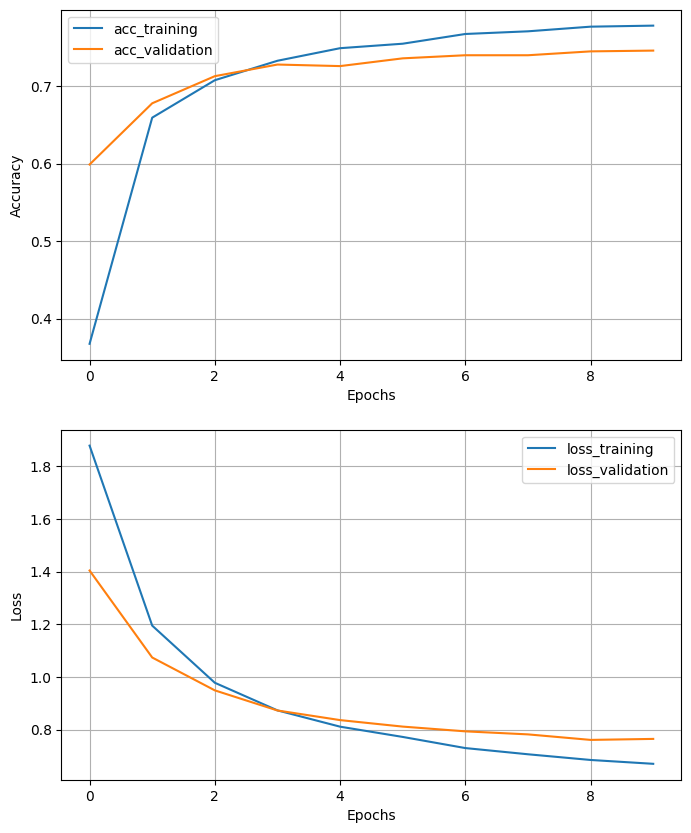

In [99]:
plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

In [100]:
test(RESNET18, dataloader_test=RES_dataloader_test)

Test Loss: 0.75007731 ---------- Test Accuracy: 74.9000%
